In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../Work/Abstract/PaperBin/AllThreeSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['allThreeYesWrat']
    groups = splits['groups']
    
print(len(subids))

593


In [2]:
import numpy as np

subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', 'rest', meta[subid]['rest']) for subid in subidsNp]
nback_ts = [loadSeries('../../PNC', 'nback', meta[subid]['nback']) for subid in subidsNp]
emoid_ts = [loadSeries('../../PNC', 'emoid', meta[subid]['emoid']) for subid in subidsNp]

print('Loading complete')

Loading complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(rest_ts)
normalizeSubjects(nback_ts)
normalizeSubjects(emoid_ts)

print('Complete')

Complete


In [4]:
# Calculate pearson matrices

rest_p = np.stack([np.corrcoef(sub) for sub in rest_ts])
nback_p = np.stack([np.corrcoef(sub) for sub in nback_ts])
emoid_p = np.stack([np.corrcoef(sub) for sub in emoid_ts])

print(rest_p.shape)
print('Complete')

(593, 264, 264)
Complete


In [5]:
# Create feature vectors (right now just ages, maleness, and femaless)

males = 0
females = 0

X_all = []
for subid in subidsNp:
    subj = meta[subid]
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_all.append(feat)
    if maleness == 1:
        males += 1
    if femaleness == 1:
        females += 1
X_all = np.vstack(X_all)

print(f'{males} {females}')
print(X_all[10:20])
print('Complete')

271 322
[[223   1   0]
 [190   0   1]
 [197   0   1]
 [145   1   0]
 [148   0   1]
 [142   0   1]
 [123   1   0]
 [176   1   0]
 [129   0   1]
 [173   1   0]]
Complete


In [6]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

rest_p_t = convertTorch(rest_p)
nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(rest_p_t.shape)
print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([593, 34716])
torch.Size([593, 34716])
torch.Size([593, 34716])
Complete


In [7]:
wratDict = dict()

with open('../../PNC/wrat.csv', 'r') as f:
    lines = f.readlines()[1:]
    for line in lines:
        line = line.strip().split(',')
        wratDict[line[0]] = {'raw': line[2], 'std': line[3]}

wrat = []

for key in subids:
    wrat.append(float(wratDict[str(key)]['std']))
    
wrat = np.array(wrat)
wrat_t = torch.from_numpy(wrat).float().cuda()

print('Complete')

Complete


In [8]:
import torch.nn as nn
import torch.nn.functional as F

def makePoly(ps):
    pps = []
    for i in range(ps.shape[0]):
        p = ps[i].flatten()
        pp = nPoly*[None]
        for j in range(nPoly):
            pp[j] = p**(j+1)
        pps.append(torch.stack(pp))
    return torch.stack(pps)

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e))

class MiniPgi(nn.Module):
    def __init__(self, w, nPara, nPoly, nTgts, dp=0.5, relu=0.1):
        super(MiniPgi, self).__init__()
        self.masks = []
        for i in range(nTgts):
            self.masks.append(nn.Parameter(
                0.01*torch.ones(nPara,nPoly,arith(263),w).float().cuda()
                +0.001*torch.randn(nPara,nPoly,arith(263),w).float().cuda()
            ))
        self.dp = nn.Dropout(p=dp)
        self.relu = []
        for i in range(nTgts):
            rel = relu if type(relu) == float or type(relu) == int else relu[i]
            self.relu.append(nn.LeakyReLU(negative_slope=rel))
        
    def forward(self, x, age=None, gender=None, wrat=None):
        x = self.dp(x)
        lbls = [age, gender, wrat]
        res = []
        es = []
        for i,lbl in enumerate(lbls):
            y = torch.einsum('abcd,bcde->ae', x, self.masks[i])
            e = y@y.T
            es.append(e)
            idcs = torch.logical_not(torch.any(lbl, dim=1))
            e[:,idcs] = 0
            e = self.relu[i](mask(e))
            s = torch.sum(e, dim=1)
            e = e/s.unsqueeze(1)
            res.append(e@lbl)
        return res, es
        
print('Complete')

Complete


In [219]:
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 15000
pPeriod = 100
thresh = torch.Tensor((80,2e-1,40)).float().cuda()

nPoly = 1
para = [makePoly(nback_p_t), makePoly(emoid_p_t)]
    
rmse = []

for i in range(10):
#     pgigcn = MiniPgi(10, len(para), nPoly, 3, 0.5, (0.2, 0.01, 1))
#     optim = torch.optim.Adam(pgigcn.masks, lr=2e-5, weight_decay=2e-5)
    pgigcn = GCN(40, len(para), nPoly, 3, 0.5)
    optim = torch.optim.Adam(pgigcn.parameters(), lr=2e-5, weight_decay=2e-5)

    trainIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    X = torch.stack(para, dim=1)
    X = X[trainIdcs]
    Y = torch.from_numpy(X_all[trainIdcs]).float().cuda()
    
    gen = Y[:,1:]
    wrt = wrat_t[trainIdcs].unsqueeze(1)
    age = Y[:,0].unsqueeze(1)
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res = pgigcn(X, age=age, gender=gen, wrat=wrt)
        loss0 = mseLoss(res[0], age)
        loss1 = ceLoss(res[1], gen)
        loss2 = mseLoss(res[2], wrt)
        loss = torch.stack([loss0, loss1, loss2])
        torch.sum(loss).backward()
        optim.step()
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={(float(loss0), float(loss1), float(loss2))}')
        if torch.all(loss < thresh):
            print('Early stopping')
            break
            
    print('Finished training')
    
    pgigcn.eval()
    
    X = torch.stack(para, dim=1)
    Y = torch.from_numpy(X_all).float().cuda()
        
    gen = Y[:,1:]
    wrt = wrat_t.unsqueeze(1)
    age = Y[:,0].unsqueeze(1)

    gen0 = gen.clone().detach()
    gen0[testIdcs] = 0
    wrt0 = wrt.clone().detach()
    wrt0[testIdcs] = 0
    age0 = age.clone().detach()
    age0[testIdcs] = 0
    
    res = pgigcn(X, age=age0, gender=gen0, wrat=wrt0)
    loss0 = mseLoss(res[0][testIdcs].detach(), age[testIdcs]).cpu().numpy()**0.5
    frac1 = torch.sum(torch.argmax(res[1].detach(), dim=1)[testIdcs] 
                     == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]
    loss2 = mseLoss(res[2][testIdcs].detach(), wrt[testIdcs]).cpu().numpy()**0.5
    
    rmse.append((float(loss0), float(frac1), float(loss2)))
    print(i, end=' ')
    print(rmse[-1])

epoch 0 loss=(34356.73046875, 0.6892601251602173, 10770.7490234375)
epoch 100 loss=(3342.408447265625, 14.127725601196289, 860.6365966796875)
epoch 200 loss=(2475.087890625, 8.74641227722168, 322.0522766113281)
epoch 300 loss=(2220.810546875, 1.575121283531189, 281.592529296875)
epoch 400 loss=(1994.09375, 1.1781543493270874, 259.7020263671875)
epoch 500 loss=(1812.14794921875, 1.3416664600372314, 251.16204833984375)
epoch 600 loss=(1667.5797119140625, 1.3973873853683472, 250.02137756347656)
epoch 700 loss=(1555.588623046875, 1.3950055837631226, 251.5443878173828)
epoch 800 loss=(1465.3126220703125, 1.3294774293899536, 252.66419982910156)
epoch 900 loss=(1397.0595703125, 1.224228024482727, 252.66751098632812)
epoch 1000 loss=(1340.791748046875, 1.082519292831421, 251.71006774902344)
epoch 1100 loss=(1301.86376953125, 0.9479101896286011, 250.9268341064453)
epoch 1200 loss=(1270.6766357421875, 0.8478869795799255, 249.64492797851562)
epoch 1300 loss=(1242.7872314453125, 0.7698935866355896

epoch 10900 loss=(35.68893051147461, 0.37001410126686096, 13.75341510772705)
epoch 11000 loss=(35.63298034667969, 0.37096330523490906, 13.438542366027832)
epoch 11100 loss=(31.697607040405273, 0.36949092149734497, 13.004411697387695)
epoch 11200 loss=(35.359962463378906, 0.3609299063682556, 9.950973510742188)
epoch 11300 loss=(35.89720153808594, 0.35302087664604187, 12.759252548217773)
epoch 11400 loss=(30.70734214782715, 0.36534422636032104, 11.684103012084961)
epoch 11500 loss=(29.967037200927734, 0.35343751311302185, 12.897727012634277)
epoch 11600 loss=(33.656211853027344, 0.3462008833885193, 11.038800239562988)
epoch 11700 loss=(31.3634090423584, 0.34333157539367676, 13.42618465423584)
epoch 11800 loss=(33.630619049072266, 0.3386926054954529, 10.68406867980957)
epoch 11900 loss=(35.073951721191406, 0.3361932635307312, 10.922505378723145)
epoch 12000 loss=(31.404380798339844, 0.33757761120796204, 10.96273136138916)
epoch 12100 loss=(33.018470764160156, 0.33082863688468933, 10.65810

epoch 6500 loss=(174.34033203125, 0.5195513367652893, 81.17807006835938)
epoch 6600 loss=(159.37266540527344, 0.5184041261672974, 78.739013671875)
epoch 6700 loss=(146.3401641845703, 0.5181519389152527, 74.3351058959961)
epoch 6800 loss=(145.09130859375, 0.5151187181472778, 69.44391632080078)
epoch 6900 loss=(136.03231811523438, 0.5034183859825134, 66.7623291015625)
epoch 7000 loss=(129.41505432128906, 0.5018207430839539, 64.51425170898438)
epoch 7100 loss=(130.34690856933594, 0.4933115541934967, 60.551151275634766)
epoch 7200 loss=(111.4366683959961, 0.4961828291416168, 59.76736831665039)
epoch 7300 loss=(104.73654174804688, 0.4904756546020508, 53.868080139160156)
epoch 7400 loss=(103.27442169189453, 0.4824196994304657, 50.25917053222656)
epoch 7500 loss=(94.75049591064453, 0.4787808358669281, 48.947021484375)
epoch 7600 loss=(89.6080322265625, 0.4660957157611847, 47.52576446533203)
epoch 7700 loss=(84.30463409423828, 0.4625184237957001, 44.24424362182617)
epoch 7800 loss=(78.42491149

epoch 2600 loss=(916.4573364257812, 0.6750541925430298, 193.2520751953125)
epoch 2700 loss=(895.3868408203125, 0.6693183779716492, 191.05072021484375)
epoch 2800 loss=(873.1363525390625, 0.6679407954216003, 189.50328063964844)
epoch 2900 loss=(848.7347412109375, 0.6583871245384216, 187.4261932373047)
epoch 3000 loss=(833.0697021484375, 0.6594201922416687, 184.71444702148438)
epoch 3100 loss=(810.1107177734375, 0.6611530780792236, 182.6865997314453)
epoch 3200 loss=(785.1355590820312, 0.6544987559318542, 180.43600463867188)
epoch 3300 loss=(768.359130859375, 0.6464167833328247, 178.451416015625)
epoch 3400 loss=(748.9642944335938, 0.648076057434082, 175.41566467285156)
epoch 3500 loss=(726.0905151367188, 0.6431788206100464, 173.4097137451172)
epoch 3600 loss=(708.5702514648438, 0.6406373381614685, 171.40252685546875)
epoch 3700 loss=(685.1307373046875, 0.6420516967773438, 169.09251403808594)
epoch 3800 loss=(666.6702880859375, 0.6412068605422974, 166.4605255126953)
epoch 3900 loss=(645.

epoch 13400 loss=(31.18669319152832, 0.3113628327846527, 9.810646057128906)
epoch 13500 loss=(36.73444747924805, 0.296626478433609, 10.60896110534668)
epoch 13600 loss=(39.978965759277344, 0.28623971343040466, 9.328393936157227)
epoch 13700 loss=(35.55405044555664, 0.28400346636772156, 10.609560012817383)
epoch 13800 loss=(34.430564880371094, 0.2842578589916229, 11.024502754211426)
epoch 13900 loss=(33.597694396972656, 0.29503753781318665, 10.606837272644043)
epoch 14000 loss=(35.225162506103516, 0.2912326455116272, 9.812630653381348)
epoch 14100 loss=(32.0417366027832, 0.28150832653045654, 11.248828887939453)
epoch 14200 loss=(32.56589889526367, 0.27873674035072327, 10.93210220336914)
epoch 14300 loss=(34.08009719848633, 0.27570998668670654, 9.997740745544434)
epoch 14400 loss=(35.402557373046875, 0.2606024146080017, 10.17635440826416)
epoch 14500 loss=(32.94259262084961, 0.2654147446155548, 10.28441333770752)
epoch 14600 loss=(35.5040283203125, 0.28000861406326294, 10.761906623840332

epoch 9100 loss=(52.459285736083984, 0.3473733067512512, 17.13123893737793)
epoch 9200 loss=(49.74173355102539, 0.341569721698761, 17.984127044677734)
epoch 9300 loss=(51.241939544677734, 0.3404122292995453, 17.154590606689453)
epoch 9400 loss=(45.33974838256836, 0.3313780426979065, 15.501279830932617)
epoch 9500 loss=(45.94810104370117, 0.32785752415657043, 15.42088794708252)
epoch 9600 loss=(45.03618240356445, 0.32154762744903564, 16.535114288330078)
epoch 9700 loss=(39.319026947021484, 0.31972265243530273, 15.08818244934082)
epoch 9800 loss=(39.65130615234375, 0.3171282112598419, 15.409366607666016)
epoch 9900 loss=(40.8817138671875, 0.3042983114719391, 15.374292373657227)
epoch 10000 loss=(43.09428405761719, 0.3037133812904358, 14.740116119384766)
epoch 10100 loss=(43.621681213378906, 0.30262893438339233, 13.054230690002441)
epoch 10200 loss=(39.65077590942383, 0.31282564997673035, 13.123016357421875)
epoch 10300 loss=(40.84294509887695, 0.29497331380844116, 11.90457820892334)
epoc

epoch 6500 loss=(221.4879150390625, 0.4582119286060333, 72.70441436767578)
epoch 6600 loss=(210.7046661376953, 0.45552390813827515, 67.57713317871094)
epoch 6700 loss=(202.5347442626953, 0.45515304803848267, 63.64442825317383)
epoch 6800 loss=(186.73574829101562, 0.4476466774940491, 60.99814987182617)
epoch 6900 loss=(169.9232177734375, 0.44102004170417786, 59.19126510620117)
epoch 7000 loss=(165.4702911376953, 0.44144436717033386, 56.424346923828125)
epoch 7100 loss=(157.34266662597656, 0.4271910488605499, 54.35063934326172)
epoch 7200 loss=(146.75527954101562, 0.4398230314254761, 52.3759880065918)
epoch 7300 loss=(142.9299774169922, 0.4293438196182251, 48.31447982788086)
epoch 7400 loss=(134.74989318847656, 0.4220675826072693, 47.08094024658203)
epoch 7500 loss=(126.98931884765625, 0.4304651618003845, 43.406280517578125)
epoch 7600 loss=(117.67220306396484, 0.4134591221809387, 41.15968704223633)
epoch 7700 loss=(112.11023712158203, 0.41209691762924194, 39.28480911254883)
epoch 7800 l

epoch 3500 loss=(605.090576171875, 0.6698721647262573, 172.4866485595703)
epoch 3600 loss=(593.9544067382812, 0.667195737361908, 166.6100616455078)
epoch 3700 loss=(569.49609375, 0.6623127460479736, 166.15782165527344)
epoch 3800 loss=(544.2706298828125, 0.6596415638923645, 161.92617797851562)
epoch 3900 loss=(526.5192260742188, 0.6583424210548401, 158.31175231933594)
epoch 4000 loss=(504.8553466796875, 0.6520377993583679, 155.9981231689453)
epoch 4100 loss=(481.1515197753906, 0.6538997888565063, 152.1075897216797)
epoch 4200 loss=(469.56591796875, 0.6512361764907837, 148.94607543945312)
epoch 4300 loss=(451.828369140625, 0.645906388759613, 146.04287719726562)
epoch 4400 loss=(434.7247314453125, 0.6463437080383301, 142.21258544921875)
epoch 4500 loss=(415.01556396484375, 0.6480115056037903, 139.2886199951172)
epoch 4600 loss=(396.3794860839844, 0.6460322141647339, 136.4446258544922)
epoch 4700 loss=(372.56756591796875, 0.6401165127754211, 133.8375244140625)
epoch 4800 loss=(363.7151489

epoch 14300 loss=(30.149717330932617, 0.2800443470478058, 9.977638244628906)
epoch 14400 loss=(34.95531463623047, 0.2868320345878601, 10.662153244018555)
epoch 14500 loss=(34.75075149536133, 0.2719411253929138, 10.770304679870605)
epoch 14600 loss=(37.492774963378906, 0.27594897150993347, 9.312315940856934)
epoch 14700 loss=(31.075557708740234, 0.27125436067581177, 10.361973762512207)
epoch 14800 loss=(31.213512420654297, 0.2652588486671448, 10.3928804397583)
epoch 14900 loss=(29.805927276611328, 0.2654329240322113, 10.699374198913574)
epoch 14999 loss=(30.595930099487305, 0.2614014446735382, 11.001111030578613)
Finished training
5 (22.267778396606445, 0.8135592937469482, 13.721420288085938)
epoch 0 loss=(34216.4375, 0.7088958024978638, 10780.791015625)
epoch 100 loss=(3726.66845703125, 1.4443830251693726, 1384.2283935546875)
epoch 200 loss=(1897.245849609375, 1.258518934249878, 266.4745788574219)
epoch 300 loss=(1772.355224609375, 1.0275307893753052, 248.54696655273438)
epoch 400 loss

epoch 10000 loss=(36.425079345703125, 0.32855716347694397, 17.264381408691406)
epoch 10100 loss=(38.729740142822266, 0.3234878480434418, 18.241525650024414)
epoch 10200 loss=(38.02396011352539, 0.31328803300857544, 18.092248916625977)
epoch 10300 loss=(40.115394592285156, 0.3135978877544403, 16.211658477783203)
epoch 10400 loss=(39.13098907470703, 0.3001745939254761, 17.745338439941406)
epoch 10500 loss=(36.55449676513672, 0.30422499775886536, 16.34383773803711)
epoch 10600 loss=(34.700748443603516, 0.2974322736263275, 14.503067016601562)
epoch 10700 loss=(34.88117980957031, 0.28934338688850403, 14.308460235595703)
epoch 10800 loss=(31.670040130615234, 0.28957220911979675, 14.983240127563477)
epoch 10900 loss=(33.335594177246094, 0.2888162434101105, 14.290151596069336)
epoch 11000 loss=(31.892812728881836, 0.2822679579257965, 14.22936725616455)
epoch 11100 loss=(37.06501770019531, 0.2789819836616516, 12.843792915344238)
epoch 11200 loss=(33.30848693847656, 0.2775033116340637, 13.041495

epoch 7400 loss=(151.65599060058594, 0.4893481731414795, 105.99469757080078)
epoch 7500 loss=(137.67881774902344, 0.4808658957481384, 102.45347595214844)
epoch 7600 loss=(125.00226593017578, 0.4760008454322815, 100.75926208496094)
epoch 7700 loss=(126.20233917236328, 0.47569939494132996, 95.85832977294922)
epoch 7800 loss=(122.15460968017578, 0.4718310236930847, 93.56887817382812)
epoch 7900 loss=(114.28532409667969, 0.4620448350906372, 88.54042053222656)
epoch 8000 loss=(107.3095932006836, 0.4588846266269684, 86.99846649169922)
epoch 8100 loss=(102.70323944091797, 0.4578593671321869, 82.06681823730469)
epoch 8200 loss=(99.75977325439453, 0.4445746839046478, 79.12495422363281)
epoch 8300 loss=(97.37805938720703, 0.45047956705093384, 79.30146026611328)
epoch 8400 loss=(91.26023864746094, 0.44197753071784973, 71.76367950439453)
epoch 8500 loss=(86.80066680908203, 0.432553231716156, 71.37754821777344)
epoch 8600 loss=(83.86345672607422, 0.4263506233692169, 68.5189208984375)
epoch 8700 los

epoch 3000 loss=(830.6767578125, 0.6306726336479187, 204.52139282226562)
epoch 3100 loss=(809.9974365234375, 0.6295167207717896, 200.74400329589844)
epoch 3200 loss=(785.46826171875, 0.6285452842712402, 199.45071411132812)
epoch 3300 loss=(759.9725341796875, 0.6217827796936035, 196.23988342285156)
epoch 3400 loss=(738.0792236328125, 0.6157298684120178, 192.18057250976562)
epoch 3500 loss=(713.239013671875, 0.6087775826454163, 188.70150756835938)
epoch 3600 loss=(690.6488647460938, 0.6050072312355042, 185.84185791015625)
epoch 3700 loss=(664.3353881835938, 0.605449914932251, 180.78025817871094)
epoch 3800 loss=(638.5076293945312, 0.5963945388793945, 178.09278869628906)
epoch 3900 loss=(610.7803344726562, 0.5946617126464844, 174.1092987060547)
epoch 4000 loss=(596.498046875, 0.597113311290741, 170.47474670410156)
epoch 4100 loss=(573.2755126953125, 0.5865548253059387, 167.15090942382812)
epoch 4200 loss=(552.6295776367188, 0.5834662914276123, 163.35348510742188)
epoch 4300 loss=(527.8392

epoch 2000 loss=(1136.1402587890625, 2.0523769855499268, 232.67567443847656)
epoch 2100 loss=(1119.3775634765625, 1.8857440948486328, 230.54319763183594)
epoch 2200 loss=(1101.89892578125, 1.718154788017273, 228.55300903320312)
epoch 2300 loss=(1086.2249755859375, 1.5510512590408325, 226.3761444091797)
epoch 2400 loss=(1066.6612548828125, 1.3844772577285767, 224.20037841796875)
epoch 2500 loss=(1047.289794921875, 1.2620465755462646, 222.5711669921875)
epoch 2600 loss=(1026.4178466796875, 1.1788040399551392, 220.74725341796875)
epoch 2700 loss=(1011.7186279296875, 1.1201653480529785, 219.66848754882812)
epoch 2800 loss=(991.1627197265625, 1.0919378995895386, 217.79420471191406)
epoch 2900 loss=(968.3270874023438, 1.1077044010162354, 216.16409301757812)
epoch 3000 loss=(952.223876953125, 1.1040475368499756, 214.6087646484375)
epoch 3100 loss=(931.0908813476562, 1.123435378074646, 212.5877227783203)
epoch 3200 loss=(906.4154052734375, 1.13889479637146, 210.0135498046875)
epoch 3300 loss=(

epoch 12800 loss=(31.45516586303711, 0.3111113905906677, 11.0332612991333)
epoch 12900 loss=(34.11162567138672, 0.2985171377658844, 11.562252044677734)
epoch 13000 loss=(34.8726806640625, 0.2920713424682617, 11.051010131835938)
epoch 13100 loss=(31.434741973876953, 0.29236724972724915, 11.104040145874023)
epoch 13200 loss=(34.69563293457031, 0.2895403504371643, 10.472949028015137)
epoch 13300 loss=(31.1857967376709, 0.28274354338645935, 10.517436027526855)
epoch 13400 loss=(31.393230438232422, 0.28018319606781006, 10.307604789733887)
epoch 13500 loss=(31.09272575378418, 0.285115510225296, 11.130152702331543)
epoch 13600 loss=(30.78389549255371, 0.2770124673843384, 11.093765258789062)
epoch 13700 loss=(34.771419525146484, 0.2744654417037964, 10.476217269897461)
epoch 13800 loss=(33.55084228515625, 0.27401676774024963, 11.500442504882812)
epoch 13900 loss=(36.58882522583008, 0.2741244435310364, 11.053423881530762)
epoch 14000 loss=(30.772808074951172, 0.27387210726737976, 10.942647933959

In [222]:
for a,b,c in rmse:
    print(a)

25.322284698486328
26.60723114013672
19.459274291992188
25.55489730834961
25.010723114013672
22.267778396606445
25.686952590942383
27.94972038269043
26.380115509033203
26.091154098510742


In [82]:
class PgiBack(nn.Module):
    def __init__(self, w, nPara, nPoly, nTgts, dp=0.5, relu=0.1, mask=None):
        super(PgiBack, self).__init__()
        if mask is None:
            self.mask = nn.Parameter(
                0.0001*torch.ones(nPara,nPoly,arith(263),w).float().cuda()
                +0.00001*torch.randn(nPara,nPoly,arith(263),w).float().cuda()
            )
        else:
            self.mask = nn.Parameter(mask.clone().detach()+0.1*torch.std(mask))
        self.dp = nn.Dropout(p=dp)
        self.relu = nn.LeakyReLU(negative_slope=relu)
        
    def forward(self, x, orig, idx, lbl):
        x = self.dp(x)
        with torch.no_grad():
            y = torch.einsum('abcd,bcde->ae', x, orig.masks[idx])
        z = torch.einsum('abcd,bcde->ae', x, self.mask)
        e = y@z.T
        idcs = torch.logical_not(torch.any(lbl, dim=1))
        e[:,idcs] = 0
        e = self.relu(mask(e))
        s = torch.sum(e, dim=1)
        e = e/s.unsqueeze(1)
        return e@lbl, y, z, e
    
print('Complete')

Complete


In [92]:
nEpochs = 5000
pPeriod = 100
cPeriod = 50
thresh = torch.Tensor(20).float().cuda()

nPoly = 1
para = [makePoly(nback_p_t), makePoly(emoid_p_t)]
    
rmse = []

for i in range(1):
    back = PgiBack(10, len(para), nPoly, 3, 0.5, 1, mask=pgigcn.masks[0])
    optim = torch.optim.Adam([back.mask], lr=2e-5, weight_decay=2e-5)

    trainIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    X = torch.stack(para, dim=1)
    X = X[trainIdcs]
    Y = torch.from_numpy(X_all[trainIdcs]).float().cuda()
    
    gen = Y[:,1:]
    wrt = wrat_t[trainIdcs].unsqueeze(1)
    age = Y[:,0].unsqueeze(1)
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res, y, z, e = back(X, pgigcn, 0, gen)
#         loss = mseLoss(res, age)
        loss = ceLoss(res, gen)
        loss.backward()
#         loss2 = mseLoss(res[2], wrt)
#         loss = torch.stack([loss0, loss1, loss2])
#         torch.sum(loss).backward()
        optim.step()
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={(float(loss))}')
        if torch.all(loss < thresh):
            print('Early stopping')
            break
            
    print('Finished training')
    
#     pgigcn.load_state_dict(torch.load(savePath))
    pgigcn.eval()
    
    X = torch.stack(para, dim=1)
    Y = torch.from_numpy(X_all).float().cuda()
        
    gen = Y[:,1:]
    wrt = wrat_t.unsqueeze(1)
    age = Y[:,0].unsqueeze(1)

    gen0 = gen.clone().detach()
    gen0[testIdcs] = 0
    wrt0 = wrt.clone().detach()
    wrt0[testIdcs] = 0
    age0 = age.clone().detach()
    age0[testIdcs] = 0
    
    res = back(X, pgigcn, 0, gen0)
#     loss = mseLoss(res[0][testIdcs].detach(), age[testIdcs]).cpu().numpy()**0.5
    frac1 = torch.sum(torch.argmax(res[0].detach(), dim=1)[testIdcs] 
                     == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]
#     loss2 = mseLoss(res[2][testIdcs].detach(), wrt[testIdcs]).cpu().numpy()**0.5
    
#     rmse.append((float(loss0), float(frac1), float(loss2)))
    rmse.append((float(frac1)))
    print(i, end=' ')
    print(rmse[-1])

epoch 0 loss=0.6989180445671082
epoch 100 loss=0.7022110819816589
epoch 200 loss=0.6991075277328491
epoch 300 loss=0.7057473659515381
epoch 400 loss=0.7027868628501892
epoch 500 loss=0.6912396550178528
epoch 600 loss=0.7050478458404541
epoch 700 loss=1.445185899734497
epoch 800 loss=0.6930423974990845
epoch 900 loss=0.7172635197639465
epoch 1000 loss=0.7246091365814209
epoch 1100 loss=0.6988819241523743
epoch 1200 loss=0.7006752490997314


KeyboardInterrupt: 

In [150]:
with torch.no_grad():
    X = torch.stack(para, dim=1)
    X = X[trainIdcs]
    Y = torch.from_numpy(X_all[trainIdcs]).float().cuda()
    
    gen = Y[:,1:]
    wrt = wrat_t[trainIdcs].unsqueeze(1)
    age = Y[:,0].unsqueeze(1)
    
    res, es = pgigcn(X, age, gen, wrt)

e0 = es[0].detach().cpu().numpy()
e1 = es[1].detach().cpu().numpy()
e2 = es[2].detach().cpu().numpy()
    
print('Complete')

Complete


In [151]:
w0, v0 = np.linalg.eig(e0)
w1, v1 = np.linalg.eig(e1)
w2, v2 = np.linalg.eig(e2)

print(np.min(e0))

-1431.7374


In [154]:
from sklearn.decomposition import NMF

model = NMF(n_components=10, init='random', random_state=0, max_iter=2000, tol=1e-4)
W = model.fit_transform(1500+e0)
H = model.components_

In [155]:
print(np.max(1500+e0 - W@H))
print(np.min(1500+e0 - W@H))


39.3573
-97.33789


In [181]:
print(torch.sum(torch.sum(es[2], dim=1) < 0))
print(torch.sum(es[2] < 0, dim=1)/533)

tensor(0, device='cuda:0')
tensor([0.1707, 0.4221, 0.1876, 0.1144, 0.1839, 0.2683, 0.1689, 0.1238, 0.2664,
        0.0038, 0.3508, 0.0657, 0.1069, 0.2383, 0.1426, 0.0263, 0.1351, 0.1501,
        0.3490, 0.1632, 0.1463, 0.2195, 0.0413, 0.1088, 0.0788, 0.3471, 0.1032,
        0.1614, 0.2908, 0.1388, 0.1463, 0.0319, 0.2627, 0.0225, 0.1839, 0.3734,
        0.2008, 0.2702, 0.0094, 0.0713, 0.1088, 0.2289, 0.3977, 0.0957, 0.3321,
        0.1220, 0.1932, 0.2983, 0.2777, 0.0750, 0.3058, 0.3583, 0.2458, 0.0150,
        0.3227, 0.1745, 0.1989, 0.3321, 0.3902, 0.1163, 0.2251, 0.2627, 0.0788,
        0.0000, 0.3884, 0.2495, 0.1689, 0.3959, 0.2927, 0.2608, 0.0976, 0.3415,
        0.0056, 0.0000, 0.0638, 0.2270, 0.3002, 0.2101, 0.3621, 0.3977, 0.2101,
        0.1632, 0.2270, 0.0056, 0.2627, 0.2964, 0.2608, 0.1782, 0.2608, 0.0957,
        0.1220, 0.2233, 0.1707, 0.2983, 0.1163, 0.0075, 0.3865, 0.0544, 0.1670,
        0.1745, 0.0844, 0.3790, 0.2270, 0.2477, 0.1801, 0.3433, 0.2514, 0.3133,
        0.065

In [157]:
for i in range(3):
    print(pgigcn.masks[i][0,0,0,:])

tensor([ 0.0002,  0.0087, -0.0005, -0.0004, -0.0025,  0.0031,  0.0044,  0.0018,
         0.0031, -0.0041], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.0027, -0.0021, -0.0025, -0.0019, -0.0042, -0.0003, -0.0001, -0.0026,
        -0.0033, -0.0030], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([-0.0071, -0.0052,  0.0002, -0.0058,  0.0072,  0.0026,  0.0102, -0.0021,
        -0.0059, -0.0036], device='cuda:0', grad_fn=<SliceBackward0>)


In [173]:
# class USolve(nn.Module):
#     def __init__(self, nSub, nLat, nGraph):
#         super(USolve, self).__init__()
#         self.U = nn.Parameter(torch.rand(nSub,nLat).float().cuda())
#         self.mats = []
#         for i in range(nGraph):
#             self.mats.append(torch.rand(nLat, nSub).float().cuda())
#         self.params = [self.U] + self.mats
        
#     def forward(self):
#         return [self.U@m for m in self.mats]

# solve = USolve(es[0].shape[0], 10, 3)
optim = torch.optim.Adam(solve.params, lr=1e-5, weight_decay=1e-5)

nEpochs = 500_000
pPeriod = 10_000
thresh = 200

for epoch in range(nEpochs):
    optim.zero_grad()
    res = solve()
    loss = 0
    for i,r in enumerate(res[0:1]):
        loss += mseLoss(es[i], res[i])
    loss.backward()
    optim.step()
    if (epoch % pPeriod == 0 or epoch == nEpochs-1):
        print(f'epoch {epoch} loss={(float(loss))}')
    if loss < thresh:
        print('Early stopping')
        break

print('Finished training')

epoch 0 loss=65363.76171875
epoch 10000 loss=65360.75
epoch 20000 loss=65358.0390625
epoch 30000 loss=65355.515625
epoch 40000 loss=65353.1015625
epoch 50000 loss=65350.7578125
epoch 60000 loss=65348.46484375
epoch 70000 loss=65346.2109375
epoch 80000 loss=65343.99609375
epoch 90000 loss=65341.8046875
epoch 100000 loss=65339.63671875
epoch 110000 loss=65337.4921875
epoch 120000 loss=65335.390625
epoch 130000 loss=65333.296875
epoch 140000 loss=65331.23828125
epoch 150000 loss=65329.17578125
epoch 160000 loss=65327.15625
epoch 170000 loss=65325.15234375
epoch 180000 loss=65323.16796875
epoch 190000 loss=65321.203125
epoch 200000 loss=65319.25390625
epoch 210000 loss=65317.33203125
epoch 220000 loss=65315.41796875
epoch 230000 loss=65313.53125
epoch 240000 loss=65311.65625
epoch 250000 loss=65309.796875
epoch 260000 loss=65307.96484375
epoch 270000 loss=65306.1328125
epoch 280000 loss=65304.33203125
epoch 290000 loss=65302.54296875
epoch 300000 loss=65300.76953125
epoch 310000 loss=65299

In [217]:
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn.dense import DenseGraphConv

class GCN(nn.Module):
    def __init__(self, w, nPara, nPoly, nTgts, dp=0.5):
        super(GCN, self).__init__()
        self.gcn0 = DenseGraphConv(nPara*nPoly*arith(263),w).float().cuda()
        self.gcnAge = DenseGraphConv(w,1).float().cuda()
        self.gcnGen = DenseGraphConv(w,2).float().cuda()
        self.gcnWrt = DenseGraphConv(w,1).float().cuda()
        self.dp = nn.Dropout(p=0.5)
        
    def forward(self, x, **kwargs):
        e = torch.ones(2*[x.shape[0]]).float().cuda()/x.shape[0]
        e = mask(e)
        x = x.reshape(x.shape[0],-1)
        x = self.dp(x)
        x = F.relu(self.gcn0(x,e)).squeeze()
        age = self.gcnAge(x,e).squeeze(0)
        gen = self.gcnGen(x,e).squeeze(0)
        wrt = self.gcnWrt(x,e).squeeze(0)
        tab = {'age': age, 'gender': gen, 'wrat': wrt}
        res = [tab[key] for key in kwargs]
        return res
#         return res[0] if len(res) == 1 else res
    
class MLP(nn.Module):
    def __init__(self, w, nPara, nPoly, nTgts, dp=0.5):
        super(MLP, self).__init__()
        self.gcn0 = nn.Linear(nPara*nPoly*arith(263),w).float().cuda()
        self.gcnAge = nn.Linear(w,1).float().cuda()
        self.gcnGen = nn.Linear(w,2).float().cuda()
        self.gcnWrt = nn.Linear(w,1).float().cuda()
        self.dp = nn.Dropout(p=0.5)
        
    def forward(self, x, **kwargs):
        x = x.reshape(x.shape[0],-1)
        x = self.dp(x)
        x = F.relu(self.gcn0(x)).squeeze()
#         age = self.gcnAge(x)
#         gen = self.gcnGen(x)
        wrt = self.gcnWrt(x)
        tab = {'age': age, 'gender': gen, 'wrat': wrt}
        res = [tab[key] for key in kwargs]
        return res
#         return res[0] if len(res) == 1 else res
        
print('Complete')

Complete


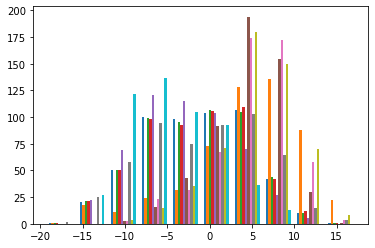

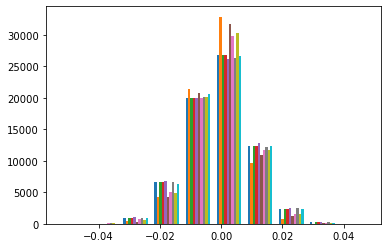

In [187]:
import matplotlib.pyplot as plt

y = torch.einsum('abcd,bcde->ae', X, pgigcn.masks[0]).detach().cpu().numpy()
m = pgigcn.masks[0].reshape(-1,10).detach().cpu().numpy()

plt.hist(y)
plt.show()

plt.hist(m)
plt.show()